In [1]:
!.\venv\Scripts\activate

In [60]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

Again load data and prepare as for manual stage (see data_analysis.ipynb)

In [3]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df.sort_index()


омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        

Lets take window size=3 and now we will use SHIFT to make more train data

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
imp = IterativeImputer(estimator=LinearRegression(),
                       missing_values=np.nan, max_iter=50, imputation_order='roman')
df_imputed = imp.fit_transform(dinam_fact_df)
dinam_fact_df = pd.DataFrame(data=df_imputed, columns = dinam_fact_df.columns, index=dinam_fact_df.index)
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                     36.700000                   1.93   
        1                     36.300000                   2.00   
        2                     36.600000                   2.13   
        3                     36.500000                   2.12   
GACAAnf 0                     36.701477                   1.21   
...                                 ...                    ...   
GACBB;O 0                     36.900000                   1.22   
        1                     36.500000                   1.65   
GACXAAB 0                     36.500000                   1.11   
        1                     36.900000                   1.60   
        2                     36.600000                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90       74.000000       24.000000   
        1                 25.70       71.000000       19.000000   
        2                 32.00       71.699426       18.000000   
        3                 27.00       71.000000       18.000000   
GACAAnf 0                 20.70       55.000000       22.000000   
...                         ...             ...             ...   
GACBB;O 0                 22.34       54.000000       18.000000   
        1                244.03       69.291345       17.000000   
GACXAAB 0                 21.80       69.482981       19.773952   
        1                 60.80       75.000000       16.000000   
        2                 17.20       73.013739       15.000000   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                         15.300000   
        1                         12.100000   
        2                         10.480305   
        3                         11.298666   
GACAAnf 0                          7.800000   
...                                     ...   
GACBB;O 0                          1.430000   
        1                          3.780000   
GACXAAB 0                          4.500000   
        1                          1.100000   
        2                          9.300000   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [73]:
def split_features_targets(df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy().reshape(window*13))
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = split_features_targets(dinam_fact_df)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

2022-11-06 22:18:28,181 - ApiComposer - Initial pipeline was fitted in 1.5 sec.
2022-11-06 22:18:28,192 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-06 22:18:28,233 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-11-06 22:19:18,185 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:49<?, ?gen/s]

2022-11-06 22:19:18,192 - ApiComposer - Time for pipeline composing was 0:00:49.957022.
The remaining 0.14157361666666665 seconds are not enough to tune the hyperparameters.
2022-11-06 22:19:18,194 - ApiComposer - Composed pipeline returned without tuning.


2022-11-06 22:19:18,639 - ApiComposer - Model generation finished
2022-11-06 22:19:18,928 - FEDOT logger - Final pipeline was fitted
2022-11-06 22:19:18,929 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}


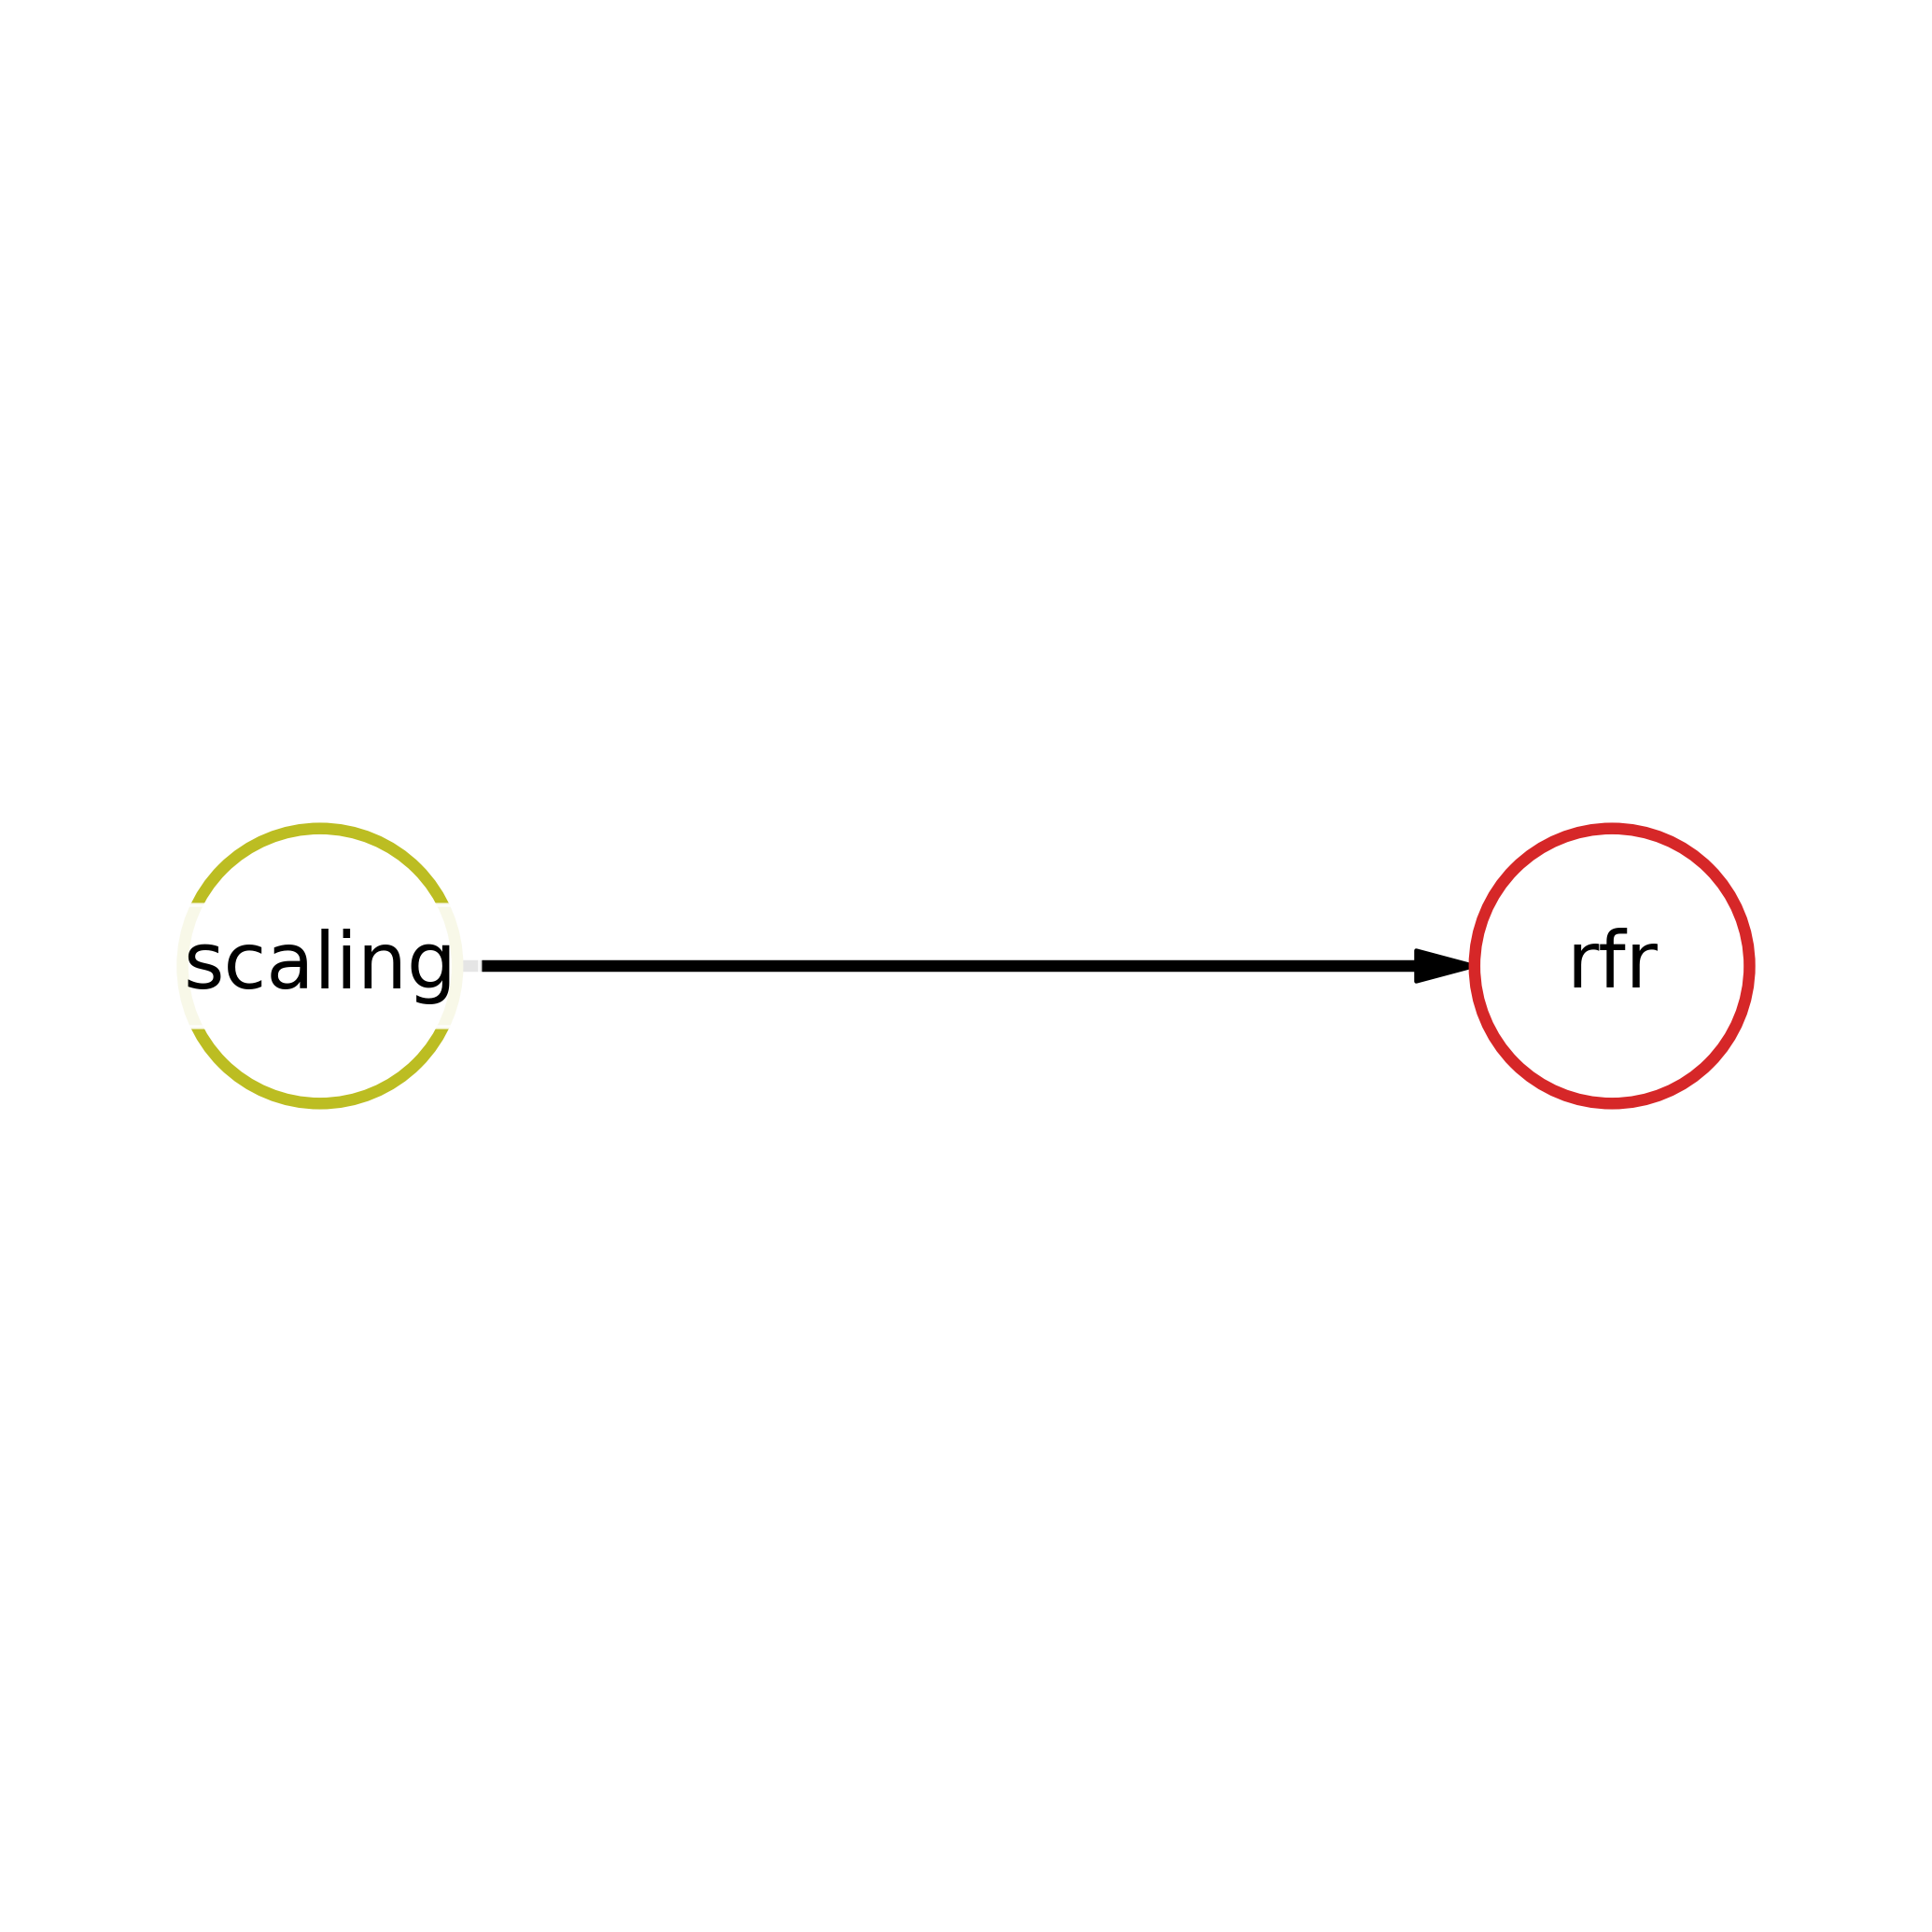

In [70]:
model = Fedot(problem='regression', timeout=1, n_jobs=-1)
obtained_pipeline = model.fit(features=X, target=y)
obtained_pipeline.show()


In [80]:
print("Scaling + RandomForestRegression results:")
y_pred = model.predict(X_test)
r2_res = r2_score(y_test, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred)
display(pd.DataFrame(data=r2_res.reshape(1, 13), columns=dinam_fact_df.columns, index=["R2"]))
print("RMSE ", mse**(1/2))

Scaling + RandomForestRegression


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-0.007477,0.066359,0.044895,0.050608,0.185909,0.153297,0.22841,0.191413,0.174683,0.431856,-0.018965,0.081241,0.249311


RMSE  160.48475733164355


Now we will try to add some statical facts. Starting with medicines

In [92]:
df.loc[("GACAk+Q", 0)].iloc[:29]

омепразол_stat_control             1
надропарин кальция_stat_control    1
эзомепразол_stat_control           1
амлодипин_stat_control             0
амброксол_stat_control             1
домперидон_stat_control            1
меброфенин_stat_control            1
технеций_stat_control              1
мометазон_stat_control             1
бисопролол_stat_control            0
дексаметазон_stat_control          0
гидрохлоротиазид_stat_control      0
гидроксихлорохин_stat_control      1
рабепразол_stat_control            0
эноксапарин натрия_stat_control    0
периндоприл_stat_control           0
ацетилцистеин_stat_control         0
азитромицин_stat_control           0
валсартан_stat_control             0
метилпреднизолон_stat_control      1
лоратадин_stat_control             0
хлорохин_stat_control              0
натрия хлорид_stat_control         0
индапамид_stat_control             0
преднизолон_stat_control           0
аторвастатин_stat_control          0
декстран_stat_control              0
л

In [91]:
df

,,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,...,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control,long_observation_tar,outcome_tar,process_stages,current_process_duration,admission_date,end_epizode
case,t_point,,,,,,,,,,,,,,,,,,,,,
GACAk+Q,0,1,1,1,0,1,1,1,1,1,0,...,0,0,0,0,9,0,1_2,3,2020-06-17,0
GACAmDB,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,16,0,2,3,2021-01-09,0
GACAmDG,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,10,1,2,3,2021-01-09,0
GACAlшш,0,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,21,0,2,3,2020-12-10,0
GACAjу.,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,13,0,1_1,3,2020-05-14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACBAk=,1,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,11,0,1_1,10,2020-05-22,1
GACBAy[,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,12,0,1_2,10,2020-06-07,1
GACBAyВ,1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,12,0,2,10,2020-12-23,1


In [100]:
def split_features_targets(df, dinam_fact_df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        sample_data = dinam_fact_df.loc[(i, 0): (i, window-1)].to_numpy().reshape(window*13)
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[:29].to_numpy()) #medicines
        X.append(sample_data)
        y.append(dinam_fact_df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = split_features_targets(df, dinam_fact_df)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

In [101]:
y

array([[ 36.8       ,   2.55      ,  17.4       , ...,   5.        ,
        216.        ,  13.4       ],
       [ 36.6003569 ,   1.32      ,  25.        , ...,   5.        ,
        262.        ,  19.9       ],
       [ 36.6       ,   2.45919027,  20.94061745, ...,   5.        ,
        253.        ,  15.28165063],
       ...,
       [ 36.6       ,   2.2065641 ,  37.10303702, ...,   5.        ,
        309.21126972,  15.21999864],
       [ 36.5       ,   1.56      ,  22.4       , ...,   5.        ,
        764.        ,  13.        ],
       [ 36.6       ,   1.51      ,  35.40138405, ...,   5.        ,
        356.15066844,  10.9       ]])

2022-11-06 22:38:06,654 - ApiComposer - Initial pipeline was fitted in 1.5 sec.
2022-11-06 22:38:06,661 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-06 22:38:06,689 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-11-06 22:38:50,758 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:44<?, ?gen/s]

2022-11-06 22:38:50,765 - ApiComposer - Time for pipeline composing was 0:00:44.075880.
The remaining 0.24116960000000004 seconds are not enough to tune the hyperparameters.
2022-11-06 22:38:50,768 - ApiComposer - Composed pipeline returned without tuning.


2022-11-06 22:38:51,232 - ApiComposer - Model generation finished
2022-11-06 22:38:51,637 - FEDOT logger - Final pipeline was fitted
2022-11-06 22:38:51,639 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}


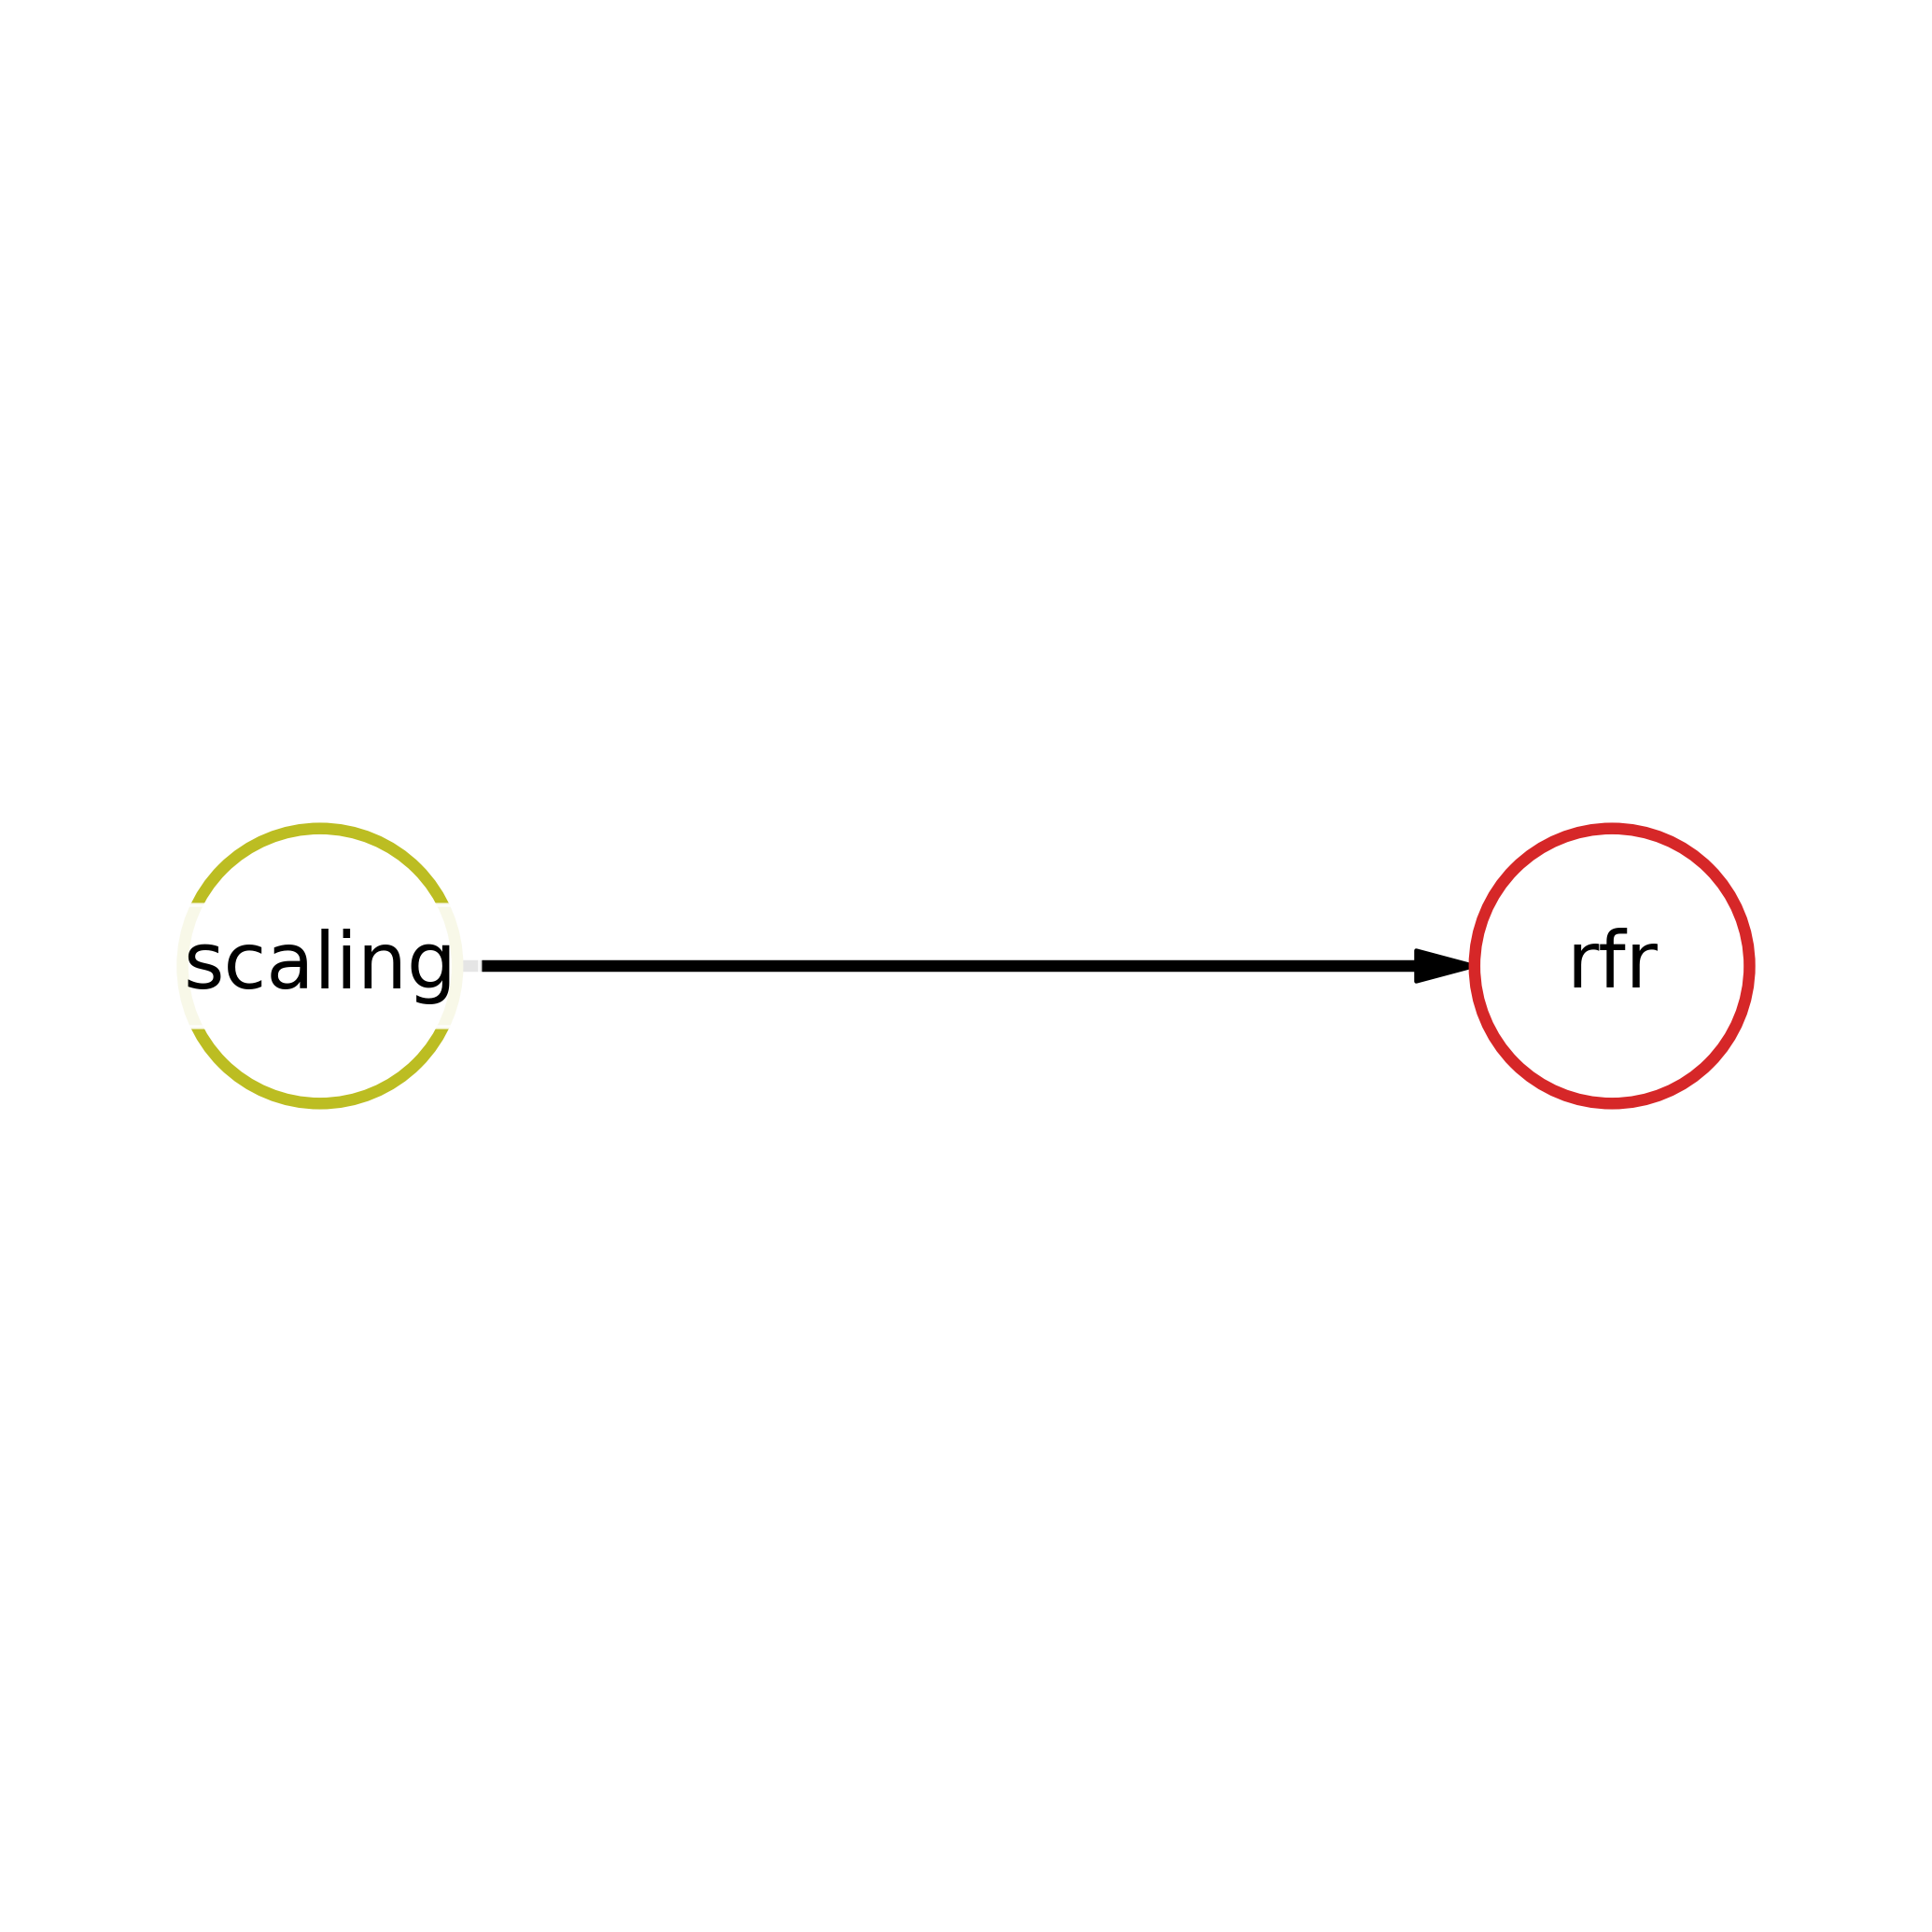

In [102]:
model_2 = Fedot(problem='regression', timeout=1, n_jobs=-1)
obtained_pipeline = model.fit(features=X, target=y)
obtained_pipeline.show()

In [ ]:
print("Add static variables:")
y_pred = model_2.predict(X_test)
r2_res = r2_score(y_test, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred)
display(pd.DataFrame(data=r2_res.reshape(1, 13), columns=dinam_fact_df.columns, index=["R2"]))
print("RMSE ", mse**(1/2))